In [626]:
from matplotlib import pyplot as plt
import math
import json
import numpy as np
import pandas as pd
from collections import OrderedDict

pcolors = OrderedDict([('blue', [0.00, 0.33, 0.66]),
                       ('green', [0.33, 0.66, 0.00]),
                       ('red', [0.66, 0.00, 0.00]),
                       ('cyan', [0.00, 0.66, 0.66]),
                       ('grey', [0.25, 0.5, 0.5]),
                       ('purple', [0.33, 0.00, 0.66]),
                       ('orange', [0.7, 0.4, 0.00])])

plt.rcParams['figure.figsize'] = (3.3, 2)
plt.rcParams['figure.dpi'] = 240
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'None'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.dpi'] = 600

%matplotlib inline

rc = %config InlineBackend.rc
rc['savefig.dpi'] = 150

In [696]:
# setup 
instance = '20a'
policy = 'edge-policy'
t_range =  [1., 1.] # [1., 0.1, 0.01, 0.001]
p_range = [1.] # [0.6, 0.7, 0.8, 0.9, 1.0]
num_particles = 1000

lsmh_range = ["smh"] # , "lmh"]
train_range = [1, 2, 5, 10, 20, 50, 100]
test_episodes = 1000
rho = 0.1
gamma = 0.9
kappa = 0.5

baseline_types = ['random-agent']

results_dir = '../results/ctp/'

In [697]:
# load instance
instances = json.load(open('../resources/ctp/instances.json', 'r'))

In [698]:
# load baselines
baseline_path = '%s/ctp-%s-%s-p%.1f-test%d.json' 
baselines = {}
for b in baseline_types:
    baselines[b] = {}
    for p in p_range:
        try:
            filename = baseline_path % (results_dir,b,instance,p,test_episodes)
            baselines[b][p] = json.load(open(filename, 'r'))
            #print '.',
            print(b, p)
        except:
           pass        

random-agent 1.0


In [708]:
# load mh trials
trial_path = '%s/ctp-%s-%s-%s-p%.1f-t%.2f-test%d.json'
lsmhtrials = {"lmh": {}, "smh": {}}
for lsmh in lsmh_range:
    for p in p_range:
        lsmhtrials[lsmh][p] = {}
        for t in t_range:
            lsmhtrials[lsmh][p][t] = {}
            try:
                filename = trial_path % (results_dir, lsmh, policy, instance, p, t, test_episodes)
                lsmhtrials[lsmh][p][t] = json.load(open(filename, 'r'))
                #print '.',
                print(lsmh, p, t)
            except Exception as e:
                print(e)
                pass        

smh 1.0 1.0
smh 1.0 1.0


In [709]:
# load trials
trial_path = '%s/ctp-%s-%s-p%.1f-rho%.1f-gamma%.1f-kappa%.1f-n%04d-steps%05d-test%d.json' 
trials = {}
for p in p_range:
    trials[p] = {}
    for n in train_range:
        try:
            filename = trial_path % (results_dir,policy,instance,p,rho,gamma,kappa,num_particles,n,test_episodes)
            trials[p][n] = json.load(open(filename, 'r'))
            #print '.',
            print(p, n)
        except:
            pass        

1.0 1
1.0 2
1.0 5
1.0 10
1.0 20
1.0 50
1.0 100


In [710]:
def plot_graph(instance, weights, axis, **kwargs):
    axis.axis("off")
    kwargs = dict(kwargs)
    if axis is None:
        axis = plt.gca()
    linewidth = kwargs.get('linewidth', 1.0)
    nodes = np.array(instance['nodes'])
    graph = np.array(instance['graph'])
    # plot edges
    for i, edges in enumerate(graph):
        for j,_ in edges:
            x = [nodes[i,0], nodes[j,0]] 
            y = [nodes[i,1], nodes[j,1]] 
            if not weights is None:
                kwargs['linewidth'] = weights.get((min(i,j), max(i,j)), 0.0) * linewidth
            axis.plot(x, y, **kwargs)
    # plot nodes
    kw = dict(kwargs)
    kw['s'] = (3 * linewidth)**2
    axis.scatter(nodes[:,0],nodes[:,1],**kw)
    # mark start and end
    s = instance['s']
    kw['s'] = (4 * linewidth)**2
    kw['color'] = pcolors['green']
    axis.scatter(nodes[[s,],0],nodes[[s,],1],zorder=np.inf,**kw)
    t = instance['t']
    kw['color'] = pcolors['red']
    axis.scatter(nodes[[t,],0],nodes[[t,],1],zorder=np.inf,**kw)
    # ax.margins(tight=True)
    xmin, xmax = nodes[:,0].min(), nodes[:,0].max()
    ymin, ymax = nodes[:,1].min(), nodes[:,1].max()
    w =  xmax - xmin 
    h = ymax - ymin
    axis.set_xlim([xmin-0.03*w, xmax+0.03*w])
    axis.set_ylim([ymin-0.03*h, ymax+0.03*h])
    #ax.set_aspect('equal')

smh: p=1.0
	T	mean	sd	min
	1.00	7.02	3.32	1.20 



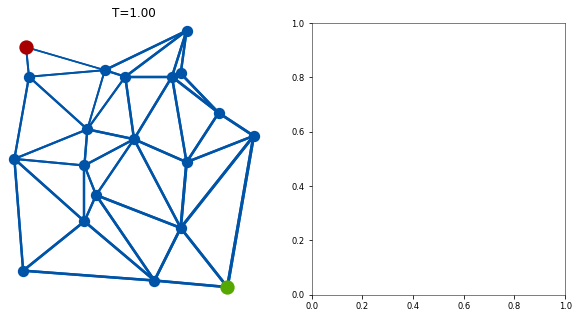

In [711]:
SAVE=False
for lsmh in sorted(list(lsmhtrials.keys())):
    for p in sorted(list(lsmhtrials[lsmh].keys())):
        fig, ax = plt.subplots(1, len(t_range), figsize=(5*len(t_range), 5))
        print("%s: p=%.1f" % (lsmh, p))
        print("\tT\tmean\tsd\tmin")
        for i, t in enumerate(sorted(list(lsmhtrials[lsmh][p].keys()))):
            trial = lsmhtrials[lsmh][p][t]
            # get map of edge weights
            max_count = 1.0 * np.max(list(trial['counts'].values()))
            weights = dict((tuple(trial['edges'][k]), trial['counts'][k] / max_count)
                           for k in trial['counts'])
            plot_graph(instances[instance], weights, 
                   axis=ax[i], linewidth=3.0, color=pcolors['blue'])
            ax[i].set_title('T=%.2f' % t, fontsize=12)
            #fig.tight_layout()
            print("\t%.2f\t%.2f\t%.2f\t%.2f " %(t, 
                                                np.mean(trial['distances']), 
                                                np.std(trial['distances']), 
                                                np.min(trial['distances'])))
        if SAVE:
            for ext in ['png','pdf','svg']:
                plotfile = '../plots/ctp/ctp_travel_graph_%s_%s_%s_%.1f_%.2f.%s' % \
                    (instance, lsmh, policy, p, t,ext)
                fig.savefig(plotfile,
                            bbox_inches='tight', dpi=600)
        print()
        plt.show()

../plots/ctp/ctp_travel_graph_20a_edge-policy_1.0_1000.png
../plots/ctp/ctp_travel_graph_20a_edge-policy_1.0_1000.pdf
../plots/ctp/ctp_travel_graph_20a_edge-policy_1.0_1000.svg


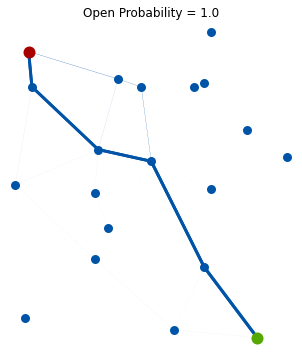

In [707]:
for p in sorted(list(trials.keys())):
    n = np.max(list(trials[p].keys()))
    trial = trials[p][n] 
    # get map of edge weights
    max_count = 1.0 * np.max(list(trial['counts'].values()))
    weights = dict((tuple(trial['edges'][k]), trial['counts'][k] / max_count)
                   for k in trial['counts'])
    fig = plt.figure(figsize=(4,5))
    ax = fig.add_axes([0,0.0,1.0,0.9], frameon=False)
    plot_graph(instances[instance], weights, 
           axis=ax, linewidth=3.0, color=pcolors['blue'])
    ax.set_title('Open Probability = %.1f' % p, fontsize=12)
    #fig.tight_layout()
    for ext in ['png','pdf','svg']:
        plotfile = '../plots/ctp/ctp_travel_graph_%s_%s_%.1f_%04d.%s' % (instance,policy,p,num_particles,ext)
        print(plotfile)
        fig.savefig(plotfile,
                    bbox_inches='tight', dpi=600)    

In [ ]:
# get traveled distance for each trial
distances = pd.DataFrame(dict(((p,n), trials[p][n]['distances']) 
                              for p in trials for n in trials[p]))

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for w,p in enumerate(p_range):
    mean_reward = distances[p].mean()
    std_reward = distances[p].std()
    for b in baselines:
        if p in baselines[b]:
            mean_baseline = np.mean(baselines[b][p]['distances'])
            print(p, b, mean_baseline)

            ax.semilogx((mean_reward.index[0],mean_reward.index[-1]),
                        (mean_baseline, mean_baseline),
                        dashes = (2,1), 
                        color = pcolors['red'], 
                        linewidth = 2 * math.sqrt(w + 1))
    ax.semilogx(mean_reward.index,
                mean_reward.values,
                '-o',
                color = pcolors['blue'], mec = pcolors['blue'],
                linewidth = 2 * math.sqrt(w  + 1), markersize=5*math.sqrt(w+1),
                label = '%.1f' % p)
        
ax.set_xlabel('Gradient Steps')
ax.set_ylabel('Mean Distance')
ax.set_xlim([1, 120])
ax.set_ylim([0.5, 3.5])
lgd =ax.legend(bbox_to_anchor=(0.3, 1.075, 0.77, .10), ncol=5, 
               handlelength=1.5, handletextpad=0.5, columnspacing=1.0)

fig.tight_layout(pad=0.05)
for ext in ['png','pdf','svg']:
    plotfile = '../plots/ctp/ctp_distance_vs_steps_%s_%s_%04d.%s' % (policy,instance,num_particles,ext)
    print('writing:', plotfile)
    fig.savefig(plotfile,
                bbox_extra_artists=(lgd,), bbox_inches='tight', 
                dpi=600,facecolor='w',edgecolor='w')

In [ ]:
for b in baselines:
    for p in baselines[b]:
        print(b, p, np.mean(baselines[b][p]['distances']))
